In [8]:
import copy
import collections
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem.Lipinski import RotatableBondSmarts
import scipy
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
import sys
sys.path.append('../')

ptable = Chem.GetPeriodicTable()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  


## Load Data

In [12]:
from eval_utils import ModelResults

result_dir = '../samples'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
ar_path = os.path.join(result_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(result_dir, 'targetdiff_vina_docked.pt')
p2m_path = os.path.join(result_dir, 'pocket2mol_vina_docked.pt')
flag_path = os.path.join(result_dir, 'flag_vina_docked.pt')
molcraft_path = os.path.join(result_dir, 'molcraft_vina_docked.pt')
train_path = os.path.join(result_dir, 'train_vina_docked.pt')
dcmp_path = os.path.join(result_dir, 'decompdiff_vina_docked.pt')
dcmp_ref_path = os.path.join(result_dir, 'decompdiff_ref_vina_docked.pt')


ref = ModelResults('Reference', ref_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
flag = ModelResults('FLAG', flag_path)
tg = ModelResults('TargetDiff', tg_path)
dcmp = ModelResults('DecompDiff-O', dcmp_path)
dcmp_ref = ModelResults('DecompDiff-R', dcmp_ref_path)
molcraft = ModelResults('MolCRAFT', molcraft_path)

models = [ref, ar, p2m, flag, tg, dcmp, dcmp_ref, molcraft]
for model in models:
    model.load_pose_checked()

Reference loaded 100 pose checked results
AR loaded 9295 pose checked results
Pocket2Mol loaded 9831 pose checked results
FLAG loaded 9863 pose checked results
TargetDiff loaded 9036 pose checked results
DecompDiff-O loaded 7196 pose checked results
DecompDiff-R loaded 8292 pose checked results
MolCRAFT loaded 9667 pose checked results


## Distance & Bond Length

(6, 6, 1), #	CC	716	29.6%	1.2857153558712793	1.696778883283098	0.004110635274118186
(6, 6, 4), #	C:C	500	20.7%	1.2981754588686738	1.5429516779717267	0.002447762191030529
(6, 8, 1), #	CO	336	13.9%	1.217717567891834	1.592581263775381	0.0037486369588354694
(6, 7, 1), #	CN	245	10.1%	1.2412786652760066	1.609101379383609	0.0036782271410760246
(6, 7, 4), #	C:N	213	8.8%	1.2781037555594505	1.4881754271876604	0.002100716716282098


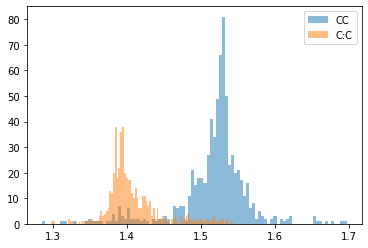

In [13]:
from core.evaluation.utils import eval_bond_length

bond_lengths = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_lengths += eval_bond_length.bond_distance_from_mol(mol)

profile = eval_bond_length.get_bond_lengths(bond_lengths)

N_BINS = 100

# plt.hist(ref.all_c_c_distance, bins=N_BINS, label='all c c pairs', alpha=0.5)

allowed_bond_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_lengths) * 100
    if freq < 10:
        continue

    if freq > 200:
        allowed_bond_types.append(k)
        bond_type_str = eval_bond_length._bond_type_str(k)
        if k[0] == k[1] == 6:
            plt.hist(profile[k], bins=N_BINS, label=bond_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{bond_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

plt.legend()
plt.show()

In [14]:
profiles = []

ref_profile = profile
N_BINS = 100

for model in models:
    bond_lengths = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        bond_lengths += eval_bond_length.bond_distance_from_mol(mol)
    profiles.append(eval_bond_length.get_bond_lengths(bond_lengths))


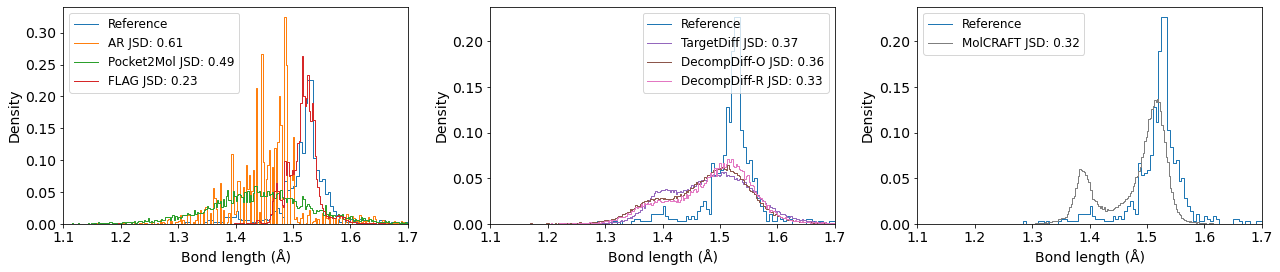

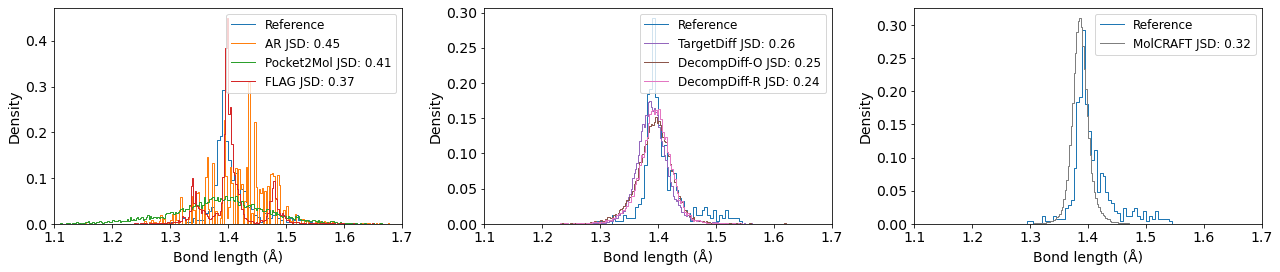

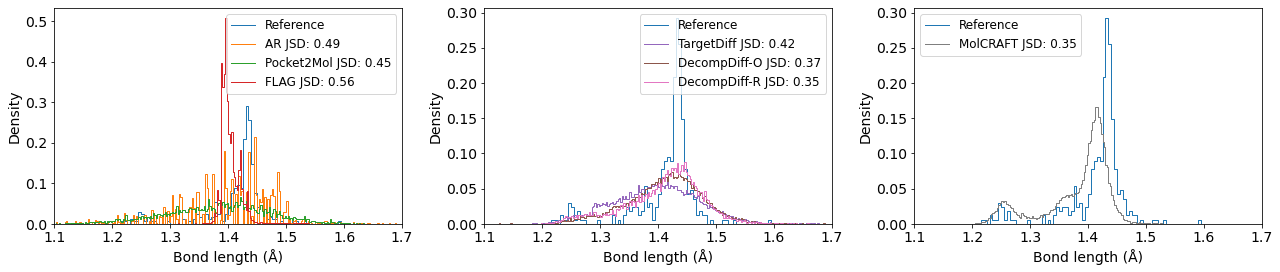

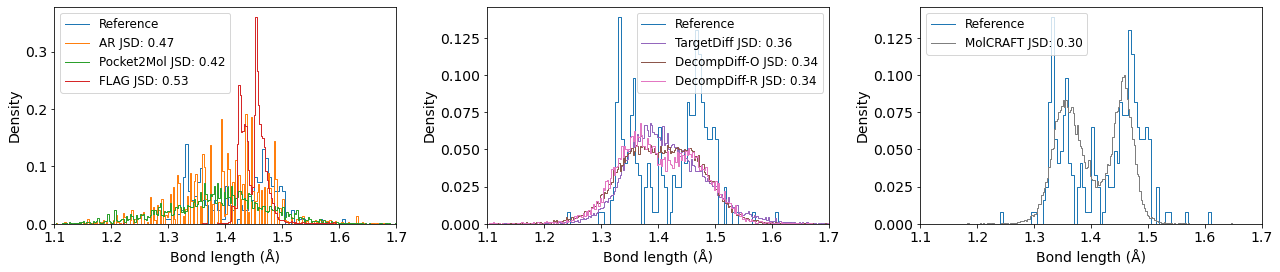

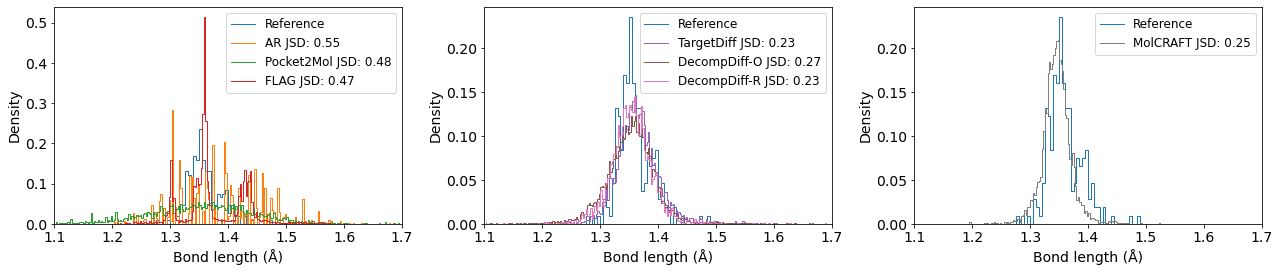

In [15]:
from scipy import spatial as sci_spatial
import seaborn as sns

BOND_LENGTH_BINS = np.arange(1.1, 1.70001, 0.005)
BOND_LENGTH_BINS_2 = np.arange(1.1, 1.70001, 0.0025)
# BOND_RANGE = (1.1, 1.7)
colors = ['tab:gray', 'tab:green', 'tab:olive', 'tab:red', 'tab:orange', 'tab:pink', 'tab:blue', 'tab:cyan', 'tab:purple', 'tab:gray', 'tab:brown'] 

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

group1 = [ar, p2m, flag]
group2 = [tg, dcmp, dcmp_ref]
group3 = [molcraft]

BOND = (6, 7, 1)
LINE_WIDTH = 1

for BOND in allowed_bond_types:
    ref_dist = np.histogram(ref_profile[BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))
    plt.subplot(1, 3, 1)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_dist = np.histogram(profiles[idx + 1][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 1][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+1])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_dist = np.histogram(profiles[idx + 4][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 4][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+4])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    # set legend to upper right
    plt.legend(loc='upper right')
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_dist = np.histogram(profiles[idx + 7][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 7][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+7])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()
    # plt.savefig(f'figs/{eval_bond_length._bond_type_str(BOND)}_length.pdf', dpi=300, bbox_inches='tight')
    plt.show()

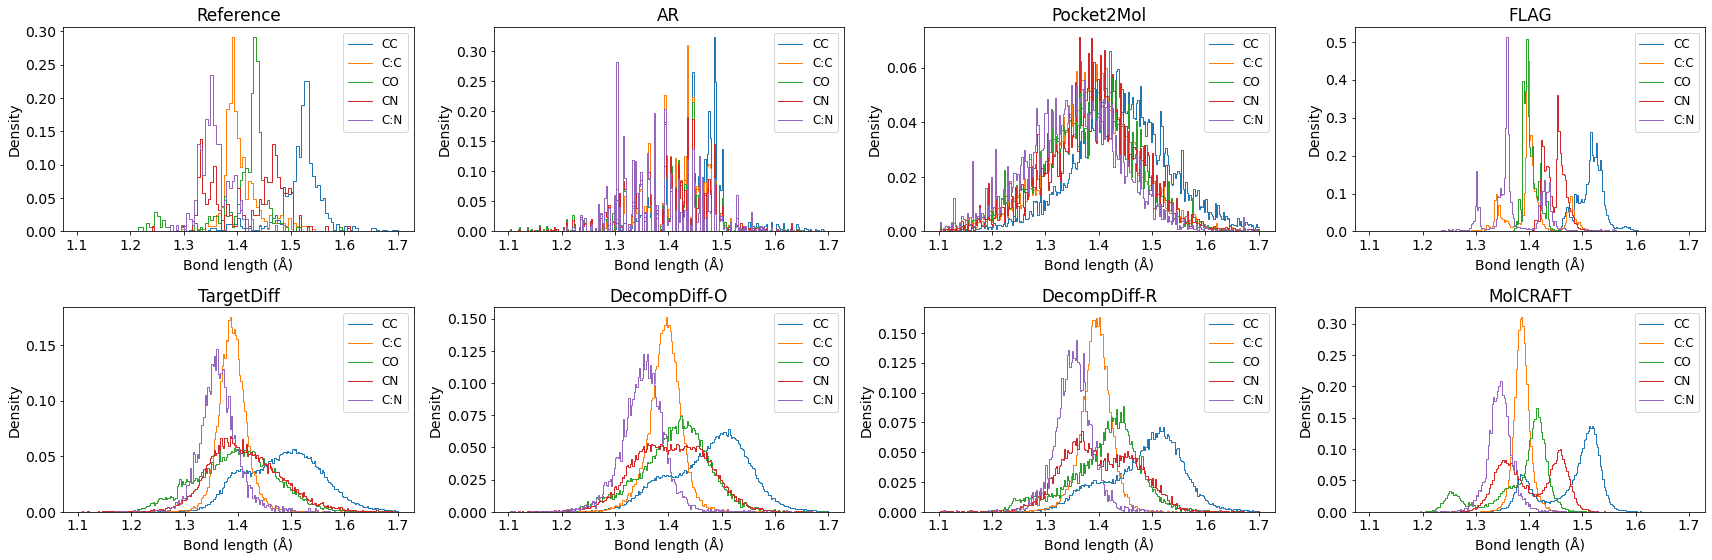

In [16]:
BINS = np.arange(1.1, 1.70001, 0.005)
BINS2 = np.arange(1.1, 1.70001, 0.0025)

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

plt.figure(figsize=(6*4, 4*2))
for idx, model in enumerate(models):
    plt.subplot(2, 4, idx+1)
    if idx == 0:
        bins = BINS
    else:
        bins = BINS2
    for BOND in allowed_bond_types:
        model_dist = np.histogram(profiles[idx][BOND], bins=bins, density=True)[0] / 100
        plt.step(bins[1:], model_dist, linewidth=1, label=f'{eval_bond_length._bond_type_str(BOND)}')
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()
    plt.title(model.name)
# plt.savefig(f'figs/all_length.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Bond Angle

(6, 1, 6, 1, 6), #	CCC	521	18.1%	59.52230720788234	135.50315793532704	0.759808507274447
(6, 4, 6, 4, 6), #	C:C:C	460	16.0%	101.54806405949785	127.54928623790771	0.2600122217840986
(6, 1, 6, 1, 8), #	CCO	274	9.5%	57.19735111082594	136.5409407542893	0.7934358964346336


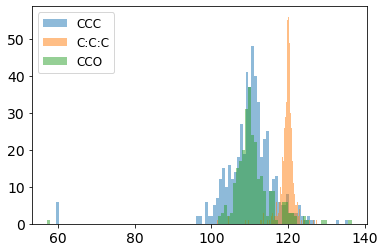

In [18]:
from core.evaluation.utils import eval_bond_angle

bond_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_angles += eval_bond_angle.bond_angle_from_mol(mol)

profile = eval_bond_angle.get_bond_angles(bond_angles)

N_BINS = 100

allowed_angle_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_angles) * 100
    if freq < 10:
        continue

    if freq > 200:
        allowed_angle_types.append(k)
        angle_type_str = eval_bond_angle._angle_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=angle_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{angle_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')
plt.legend()
plt.show()

In [21]:
# import counter
from collections import Counter

ref_profile = profile
profiles = []

error_models = []
for model in models:
    bond_angles = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        try:
            bond_angles += eval_bond_angle.bond_angle_from_mol(mol)
        except:
            error_models.append(model)
    profiles.append(eval_bond_angle.get_bond_angles(bond_angles))

error_models = Counter(error_models)
print(error_models)

atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and 

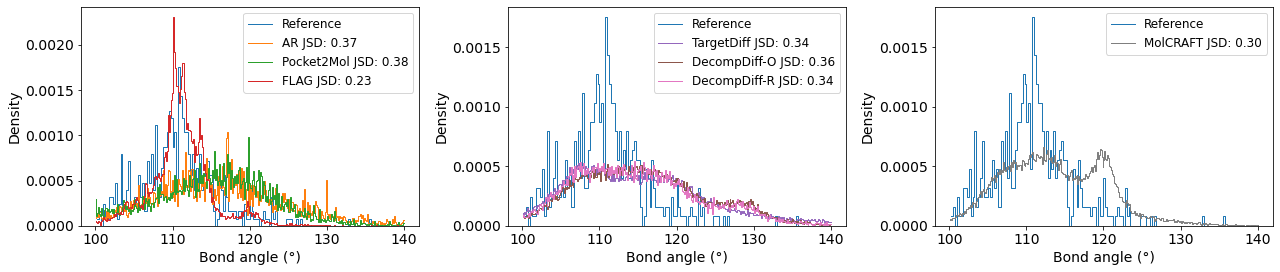

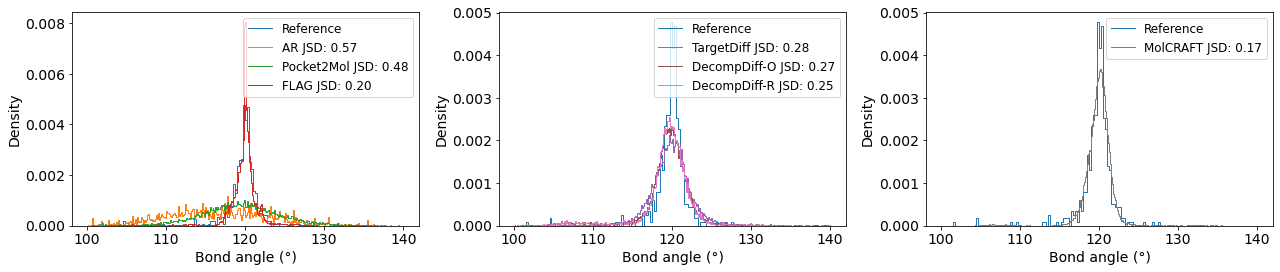

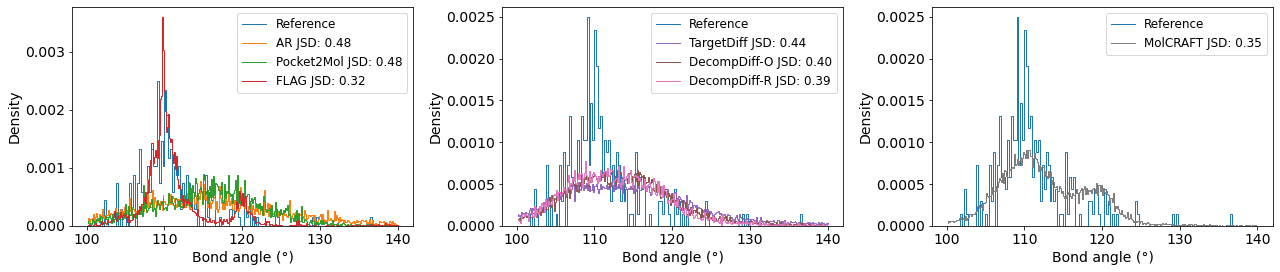

In [23]:
BOND_ANGLE_BINS = np.arange(100, 140.001, 0.25)
BOND_ANGLE_BINS_2 = np.arange(100, 140.001, 0.125)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})
LINE_WIDTH = 1

group1 = [ar, p2m, flag]
group2 = [tg, dcmp, dcmp_ref]
group3 = [molcraft]

for ANGLE in allowed_angle_types:
    ref_dist = np.histogram(ref_profile[ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))
    plt.subplot(1, 3, 1)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_dist = np.histogram(profiles[idx + 1][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 1][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+1])
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_dist = np.histogram(profiles[idx + 4][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 4][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+4])
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    # set legend to upper right
    plt.legend(loc='upper right')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.step(BOND_ANGLE_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_dist = np.histogram(profiles[idx + 7][ANGLE], bins=BOND_ANGLE_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 7][ANGLE], bins=BOND_ANGLE_BINS_2, density=True)[0] / 100
        plt.step(BOND_ANGLE_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+7])
    plt.xlabel('Bond angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'figs/{eval_bond_angle._angle_type_str(ANGLE)}_angle.pdf', dpi=300, bbox_inches='tight')
    plt.show()

## Torsion Angle

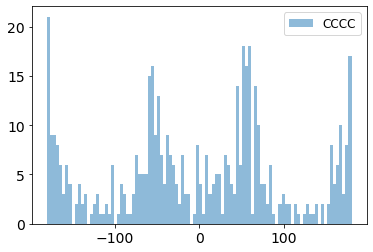

(6, 1, 6, 1, 6, 1, 6), #	CCCC	486	13.7%	-179.92344102773612	179.9786281079837	3.599020691357198


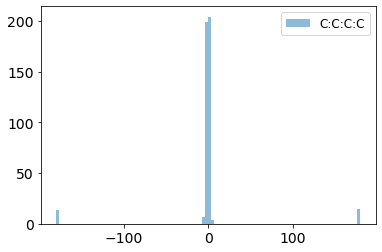

(6, 4, 6, 4, 6, 4, 6), #	C:C:C:C	443	12.5%	-179.97199569192466	179.98934915798304	3.599613448499077


In [24]:
from core.evaluation.utils import eval_torsion_angle

torsion_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)

profile = eval_torsion_angle.get_torsion_angles(torsion_angles)
N_BINS = 100

allowed_torsion_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(torsion_angles) * 100
    if freq < 10:
        continue

    if freq > 200:
        allowed_torsion_types.append(k)
        torsion_type_str = eval_torsion_angle._torsion_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=torsion_type_str, alpha=0.5, density=False)
        plt.legend()
        plt.show()
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{torsion_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

In [25]:
ref_profile = profile
profiles = []
# models = [p2m, tg, dcmp, bfn, bfn_mols, bfn_mols_v1]

for model in models:
    torsion_angles = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        try:
            torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)
        except:
            print(f'Error in {model.name}')
    profiles.append(eval_torsion_angle.get_torsion_angles(torsion_angles))

atoms k and l have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms k and l have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms k and l have identical 3D coordinates
Error in bond angle calculation
atoms k and l have identical 3D coordinates
Error in bond angle calculation
atoms j and 

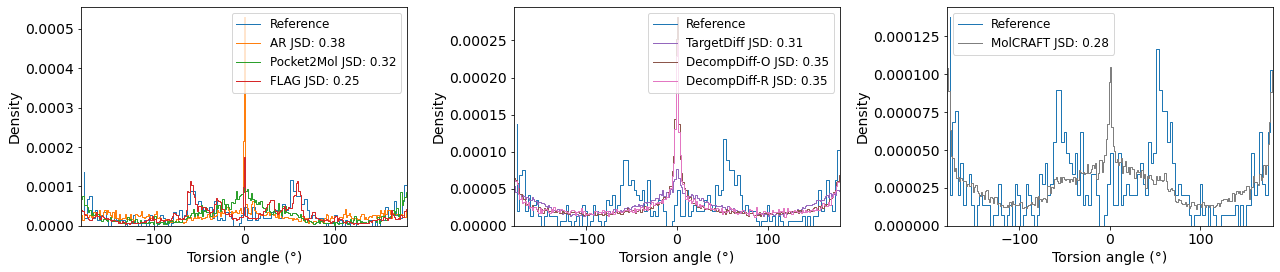

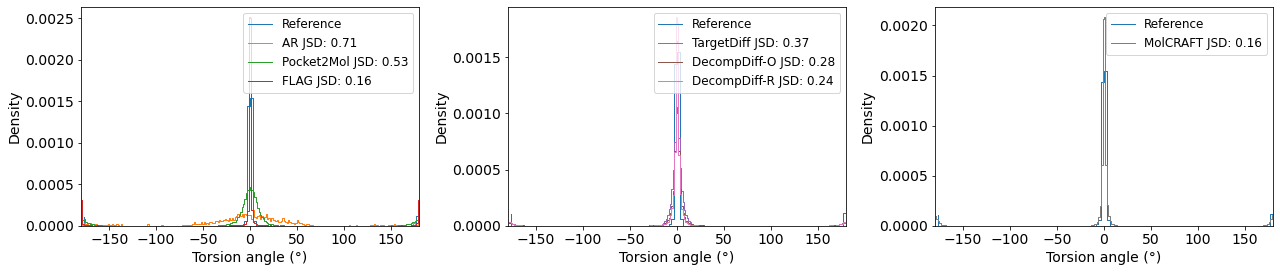

In [26]:
N_BINS = np.arange(-180, 181, 3)
N_BINS_2 = np.arange(-180, 181, 1.5)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

group1 = [ar, p2m, flag]
group2 = [tg, dcmp, dcmp_ref]
group3 = [molcraft]

for TORSION in allowed_torsion_types:
    ref_dist = np.histogram(ref_profile[TORSION], bins=N_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))
    plt.subplot(1, 3, 1)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_dist = np.histogram(profiles[idx + 1][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 1][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+1])
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.xlim(-180, 180)
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_dist = np.histogram(profiles[idx + 4][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 4][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+4])
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.xlim(-180, 180)
    plt.ylim(0)
    # set legend to upper right
    plt.legend(loc='upper right')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.step(N_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_dist = np.histogram(profiles[idx + 7][TORSION], bins=N_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 7][TORSION], bins=N_BINS_2, density=True)[0] / 100
        plt.step(N_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+7])
    plt.xlabel('Torsion angle (°)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.xlim(-180, 180)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'figs/{eval_torsion_angle._torsion_type_str(TORSION)}_torsion.pdf', dpi=300, bbox_inches='tight')
    plt.show()